In [138]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution,shgo,dual_annealing, basinhopping,direct
seed = 123

# Project: One-Mass Oscillator Optimization

## Introduction

In this project, you will apply various optimization algorithms to fit a one-mass oscillator model to real-world data. The objective is to minimize the sum of the squared residuals between the model predictions and the observed amplitudes of a one-mass oscillator system across different frequencies.

### One-Mass Oscillator Model

The one-mass oscillator is characterized by the following equation, representing the amplitudes of the system:

$$ V(\omega) = \frac{F}{\sqrt{(1 - \nu^2)^2 + 4D^2\nu^2}} $$

Here, 
- $ \omega $ represents the angular frequency of the system,
- $ \nu $ is the ratio of the excitation frequency to the natural frequency ($ \nu = \frac{\omega_{\text{err}}}{\omega_{\text{eig}}} $),
- $ D $ is the damping ratio,
- $ F $ is the force applied to the system.

The goal of the project is to determine the optimal values for the parameters $ \omega_{\text{eig}} $, $ D $, and $ F $ that result in the best fit of the one-mass oscillator model to the observed amplitudes.


### Load the real world data

- we have two different measurements
- J represents the measured frequencies
- N represents the measured amplitudes

In [139]:
df1 = pd.read_pickle("df1.pkl")
df2 = pd.read_pickle("df2.pkl")
# Printing the lengths of the DataFrames
print("Length of df1:", len(df1))
print("Length of df2:", len(df2))

Length of df1: 33
Length of df2: 66


### Low amplitudes distort the fit and are negligible therefore we define a lower threshold for N

In [140]:
threshold = 0.4
df1.sort_values("N")
max_N = max(df1["N"])
df1 = df1[df1["N"]>=threshold*max_N]

# checking the lengths of the DataFrames again 
print("Length of df1:", len(df1))
print("Length of df2:", len(df2))

Length of df1: 31
Length of df2: 66


### We extract the frequency value for maximum value of the amplitude. This serves as the initial value for one decision variable.

In [141]:
df_max=df1[df1["N"]==max(df1["N"])]
initial_Oeig = df_max["J"].values[0]
max_N = df_max["N"].values[0]

### We also have to define the other two initial guesses

In [142]:
initial_D = 0.006
initial_F = 0.120

initial_values = [initial_Oeig, initial_D, initial_F]

### Additionally we define the bounds for the decision variables



In [143]:
min_Oerr = min(df1["J"])
max_Oerr = max(df1["J"])

In [144]:
bounds = [(min_Oerr, max_Oerr), (0, 0.03), (0, 1)]

### Then we define the objective function

In [145]:
def one_mass_oscillator(params, Oerr) -> np.ndarray:
    # returns amplitudes of the system
    # Defines the model of a one mass oscilator 
    Oeig, D, F = params
    nue = Oerr / Oeig
    V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
    return V

In [146]:
def objective_function(params, Oerr, amplitudes) -> np.ndarray:
    # objective function to compare calculated and real amplitudes
    return np.sum((amplitudes - one_mass_oscillator(params, Oerr)) ** 2)

### We define the options and start the optimization process

In [147]:
options = {
    "maxfun": 100000, #Maximum Function Evaluation
    "ftol": 1e-9,     # Function Tolerance
    "xtol": 1e-9,     #Variable Tolerance
    "stepmx": 10,     #Controls Maximum Step size
    "eta": 0.25,      #Controls relative Step Size
    "gtol": 1e-5}     #Gradient Tolerance


In [148]:
J = np.array(df1["J"]) # measured frequency
N = np.array(df1["N"]) # measured amplitude

In [149]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='Nelder-Mead',
    bounds=bounds,
    options=options)


/tmp/ipykernel_975535/2959858538.py:1: OptimizeWarning: Unknown solver options: maxfun, ftol, xtol, stepmx, eta, gtol
  result = minimize(


### Then we can observe the results

In [150]:

# map optimized values to variables
resonant_frequency = result.x[0]
D = result.x[1]
F = result.x[2]
# predict the resonant amplitude with the fitted one mass oscillator.
X_pred = np.linspace(min_Oerr, max_Oerr, 1000)
ypred_one_mass_oscillator = one_mass_oscillator(result.x, X_pred)
resonant_amplitude = max(ypred_one_mass_oscillator)


In [151]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 53.54144061205875
             x: [ 8.148e+03  7.435e-04  2.153e-02]
           nit: 93
          nfev: 169
 final_simplex: (array([[ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02],
                       [ 8.148e+03,  7.435e-04,  2.153e-02]]), array([ 5.354e+01,  5.354e+01,  5.354e+01,  5.354e+01]))

### Finally, we can plot the optimized fit and the real values

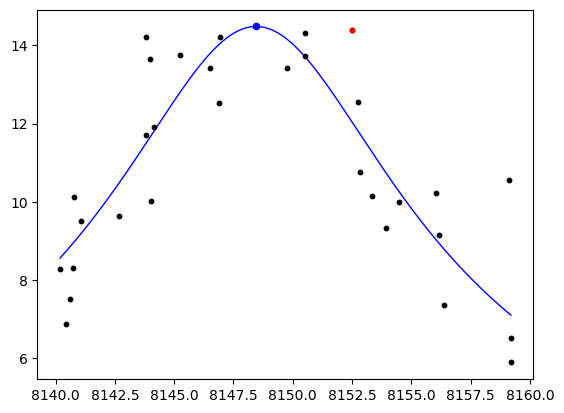

In [152]:
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
        X_pred,
        ypred_one_mass_oscillator,
        label="Alpha",
        color="blue",
        linewidth=1,
    )
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)


# Task for the Project Work


## Optimization of First Data Frame 

### Using Global Optimizers

#### Using Dual Annealing

/tmp/ipykernel_975535/2542982551.py:6: RuntimeWarning: invalid value encountered in divide
  V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
/tmp/ipykernel_975535/2542982551.py:6: RuntimeWarning: divide by zero encountered in divide
  V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
/global/mambaforge/envs/py311-pyspotseven/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


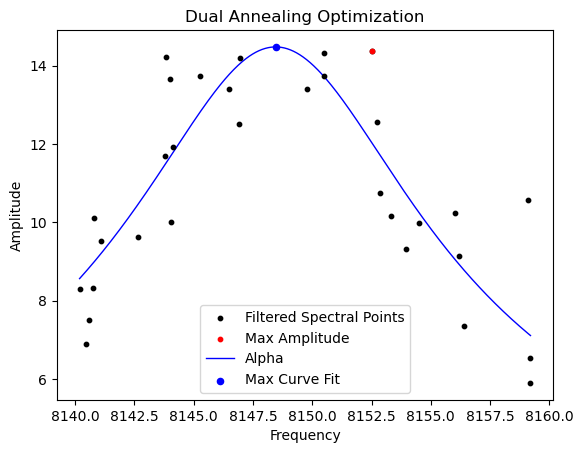

Optimized Parameters:
Resonant Frequency: 8148.45804766124
Damping Coefficient: 0.0007434644794704813
Force Amplitude: 0.02152990400035095
Resonant Amplitude: 14.479437222571885
Objective Function Value: 53.54144153462606


 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 53.54144153462606
       x: [ 8.148e+03  7.434e-04  2.153e-02]
     nit: 1000
    nfev: 6437
    njev: 109
    nhev: 0

In [153]:
result = dual_annealing(
    objective_function,
    bounds=bounds,
    args=(J, N),
    maxiter=1000,  # Maximum number of iterations
    seed=123,  # Seed for reproducibility
)

# Plotting
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Filtered Spectral Points",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Dual Annealing Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result

#### Using Differencial Evolution

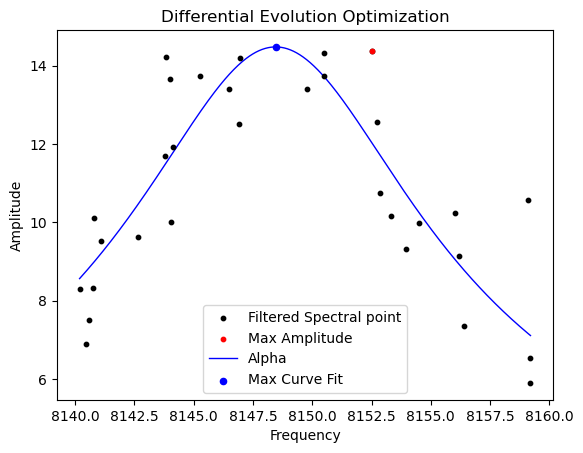

Optimized Parameters:
Resonant Frequency: 8148.45804766124
Damping Coefficient: 0.0007434644794704813
Force Amplitude: 0.02152990400035095
Resonant Amplitude: 14.479437222571885
Objective Function Value: 53.56531877262423


             message: Optimization terminated successfully.
             success: True
                 fun: 53.56531877262423
                   x: [ 8.148e+03  7.435e-04  2.153e-02]
                 nit: 43
                nfev: 2012
          population: [[ 8.148e+03  7.456e-04  2.155e-02]
                       [ 8.148e+03  7.444e-04  2.149e-02]
                       ...
                       [ 8.148e+03  7.573e-04  2.184e-02]
                       [ 8.148e+03  7.644e-04  2.199e-02]]
 population_energies: [ 5.357e+01  5.371e+01 ...  5.377e+01  5.373e+01]
                 jac: [-1.305e+00  6.588e-01  1.656e+00]

In [154]:
result = differential_evolution(
    objective_function,
    bounds=bounds,  # Define bounds for each parameter
    args=(J, N),
    maxiter=1000,  # Maximum number of iterations
    seed=123,  # Seed for reproducibility
)

# Plotting
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Filtered Spectral point",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Differential Evolution Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result

### Using Local Optimizers

#### Using Conjugate Gradient

/tmp/ipykernel_975535/2450881691.py:1: OptimizeWarning: Unknown solver options: maxfun, stepmx, eta, gtol
  result = minimize(


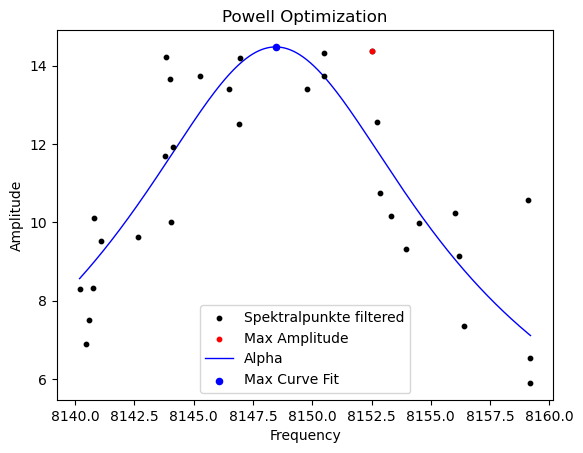

Optimized Parameters:
Resonant Frequency: 8148.45804766124
Damping Coefficient: 0.0007434644794704813
Force Amplitude: 0.02152990400035095
Resonant Amplitude: 14.479437222571885
Objective Function Value: 53.54144059016111


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 53.54144059016111
       x: [ 8.148e+03  7.435e-04  2.153e-02]
     nit: 11
   direc: [[ 1.978e+00 -1.935e-03 -3.893e-02]
           [-1.091e+00 -1.473e-05 -1.175e-04]
           [ 5.034e-08  6.736e-10 -1.229e-08]]
    nfev: 693

In [155]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='powell',
    options=options,
bounds=bounds)
# Plotting
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Powell Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result


#### Using BFGS

/tmp/ipykernel_975535/996043608.py:1: OptimizeWarning: Unknown solver options: xtol, stepmx, eta
  result = minimize(


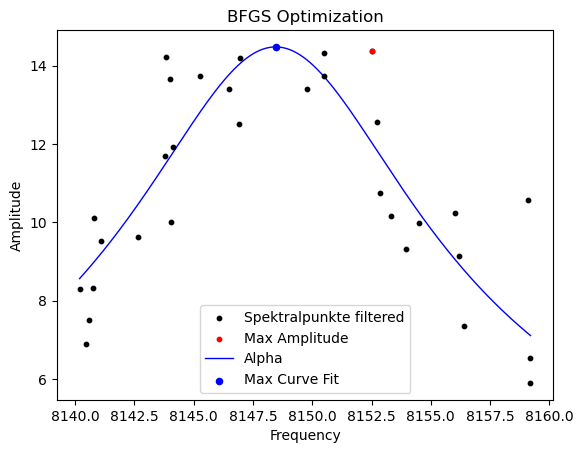

Optimized Parameters:
Resonant Frequency: 8148.45804766124
Damping Coefficient: 0.0007434644794704813
Force Amplitude: 0.02152990400035095
Resonant Amplitude: 14.479437222571885
Objective Function Value: 53.54144117175894


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 53.54144117175894
        x: [ 8.148e+03  7.434e-04  2.153e-02]
      nit: 28
      jac: [ 1.419e-03  1.073e+01 -1.476e-01]
     nfev: 188
     njev: 47
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [157]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='L-BFGS-B',
    bounds=bounds,
    options=options)
result
# Plotting
plt.scatter(
    df1["J"],
    df1["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("BFGS Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result


### Comparision of different Optimisers

| Optimizer           | Scope(local/Global optimizer)|Objective Function Value| Number of Evaluations|Number of Iterations| Observations             |
|---------------------|------------------------------|------------------------|----------------------|--------------------|--------------------------|
|Dual Annealing       | Global                        | 53.54144153462606      | 6437                  | 1000          |   Achieves a global optimum with the most function evaluations.    |
|DifferntialEvolution               | Global                       | 53.54938461678095     | 2012            | 43                  |   Finds a near-optimal solution with fewer evaluations than dual annealing.  |
|Powell's      | Local                       | 53.54144059016111   | 693               | 11               |  Powell's method efficiently finds a near-optimal solution with a lower number of iterations compared to Dual Annealing, but it may not find the absolute best solution.   |
|Nelder Mead | local                       | 53.54144061205875     | 169                 | 93                 |    Efficiently finds a near-optimal solution with fewer iterations    |
|L-BFGS-B | local                       | 53.54144117175894     | 188                 | 28                 |    Quickly converges to a local optimum with the least number of iterations.   |

### Conclusion
The table highlights the trade-off between finding the absolute best solution (global optimum) and the computational cost of the optimization algorithm. Methods that guarantee the global optimum require significant processing power, while faster approaches might settle for very good solutions that aren't necessarily the absolute best. The optimal choice depends on the specific problem and the importance placed on finding the absolute best solution versus efficiency.

## Optimization of 2nd Data Frame 

### Using Global Optimizers

In [158]:
df1 = pd.read_pickle("df1.pkl")
df2 = pd.read_pickle("df2.pkl")
# Printing the lengths of the DataFrames
print("Length of df1:", len(df1))

print("Length of df2:", len(df2))

Length of df1: 33
Length of df2: 66


In [159]:
threshold = 0.4
df2.sort_values("N")
max_N = max(df2["N"])
df2 = df2[df2["N"]>=threshold*max_N]
len(df2)

23

#### We extract the frequency value for maximum value of the amplitude. This serves as the initial value for one decision variable.

In [160]:
df_max=df2[df2["N"]==max(df2["N"])]
initial_Oeig = df_max["J"].values[0]
max_N = df_max["N"].values[0]

## We also have to define the other two initial guesses

In [161]:
initial_D = 0.006
initial_F = 0.120

initial_values = [initial_Oeig, initial_D, initial_F]

#### Additionally we define the bounds for the decision variables


In [162]:
min_Oerr = min(df2["J"])
max_Oerr = max(df2["J"])

In [163]:
bounds = [(min_Oerr, max_Oerr), (0, 0.03), (0, 1)]

#### Then we define the objective function

In [164]:
def one_mass_oscillator(params, Oerr) -> np.ndarray:
    # returns amplitudes of the system
    # Defines the model of a one mass oscilator 
    Oeig, D, F = params
    nue = Oerr / Oeig
    V = F / (np.sqrt((1 - nue**2) ** 2 + (4 * D**2 * nue**2)))
    return V

In [165]:
def objective_function(params, Oerr, amplitudes) -> np.ndarray:
    # objective function to compare calculated and real amplitudes
    return np.sum((amplitudes - one_mass_oscillator(params, Oerr)) ** 2)

#### We define the options and start the optimization process


In [166]:
options = {
    "maxfun": 100000,
    "ftol": 1e-9,
    "xtol": 1e-9,
    "stepmx": 10,
    "eta": 0.25,
    "gtol": 1e-5}
J = np.array(df2["J"]) # measured frequency
N = np.array(df2["N"]) # measured amplitude

In [167]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='Nelder-Mead',
    bounds=bounds,
    options=options)


/tmp/ipykernel_975535/2959858538.py:1: OptimizeWarning: Unknown solver options: maxfun, ftol, xtol, stepmx, eta, gtol
  result = minimize(


In [168]:
# map optimized values to variables
resonant_frequency = result.x[0]
D = result.x[1]
F = result.x[2]
# predict the resonant amplitude with the fitted one mass oscillator.
X_pred = np.linspace(min_Oerr, max_Oerr, 1000)
ypred_one_mass_oscillator = one_mass_oscillator(result.x, X_pred)
resonant_amplitude = max(ypred_one_mass_oscillator)
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 229.4092648339145
             x: [ 8.147e+03  1.099e-03  7.021e-02]
           nit: 135
          nfev: 239
 final_simplex: (array([[ 8.147e+03,  1.099e-03,  7.021e-02],
                       [ 8.147e+03,  1.099e-03,  7.021e-02],
                       [ 8.147e+03,  1.099e-03,  7.021e-02],
                       [ 8.147e+03,  1.099e-03,  7.021e-02]]), array([ 2.294e+02,  2.294e+02,  2.294e+02,  2.294e+02]))

#### Using Dual Annealing

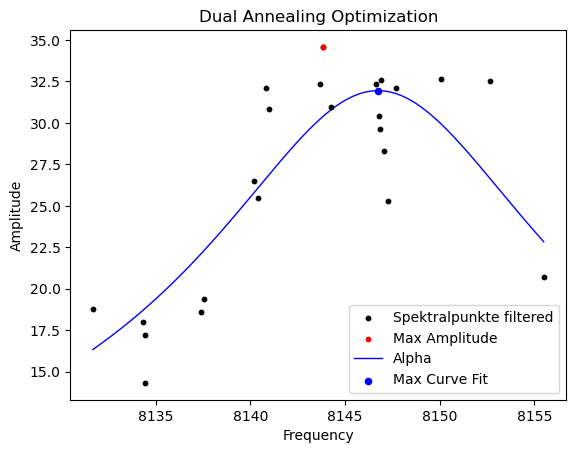

Optimized Parameters:
Resonant Frequency: 8146.746051852071
Damping Coefficient: 0.0010989248372497854
Force Amplitude: 0.07020956698446057
Resonant Amplitude: 31.94467402394625
Objective Function Value: 229.4092694161751


 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 229.4092694161751
       x: [ 8.147e+03  1.099e-03  7.020e-02]
     nit: 1000
    nfev: 6181
    njev: 45
    nhev: 0

In [169]:
result = dual_annealing(
    objective_function,
    bounds=bounds,
    args=(J, N),
    maxiter=1000,  # Maximum number of iterations
    seed=123,  # Seed for reproducibility
)

# Plotting
plt.scatter(
    df2["J"],
    df2["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Dual Annealing Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result

#### Using Differencial Evolution

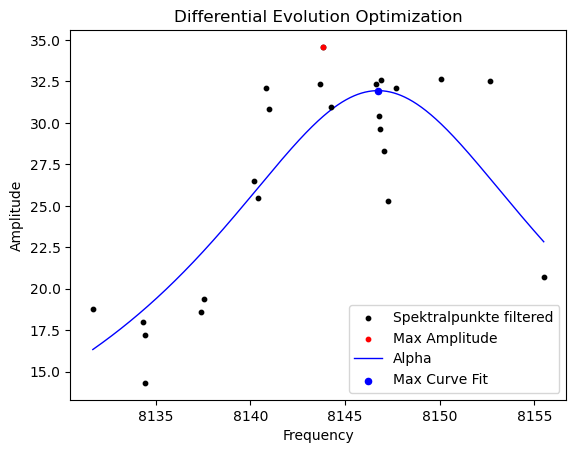

Optimized Parameters:
Resonant Frequency: 8146.746051852071
Damping Coefficient: 0.0010989248372497854
Force Amplitude: 0.07020956698446057
Resonant Amplitude: 31.94467402394625
Objective Function Value: 229.4192718479083


             message: Optimization terminated successfully.
             success: True
                 fun: 229.4192718479083
                   x: [ 8.147e+03  1.101e-03  7.035e-02]
                 nit: 37
                nfev: 1778
          population: [[ 8.147e+03  1.102e-03  7.043e-02]
                       [ 8.147e+03  1.109e-03  7.042e-02]
                       ...
                       [ 8.147e+03  1.178e-03  7.560e-02]
                       [ 8.147e+03  1.097e-03  7.063e-02]]
 population_energies: [ 2.294e+02  2.299e+02 ...  2.351e+02  2.303e+02]
                 jac: [ 7.201e-01 -1.267e+00 -4.011e+00]

In [170]:
result = differential_evolution(
    objective_function,
    bounds=bounds,  # Define bounds for each parameter
    args=(J, N),
    maxiter=1000,  # Maximum number of iterations
    seed=123,  # Seed for reproducibility
)

# Plotting
plt.scatter(
    df2["J"],
    df2["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Differential Evolution Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result

### Using Local Optimizers

#### Using Conjugate Gradient

/tmp/ipykernel_975535/110192510.py:1: OptimizeWarning: Unknown solver options: maxfun, stepmx, eta, gtol
  result = minimize(


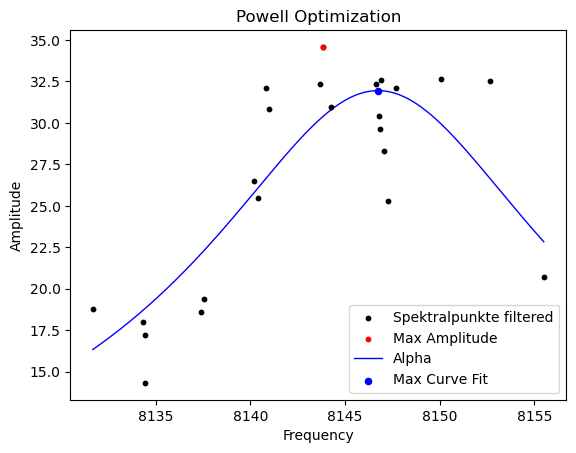

Optimized Parameters:
Resonant Frequency: 8146.746051852071
Damping Coefficient: 0.0010989248372497854
Force Amplitude: 0.07020956698446057
Resonant Amplitude: 31.94467402394625
Objective Function Value: 229.4092648056204


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 229.4092648056204
       x: [ 8.147e+03  1.099e-03  7.021e-02]
     nit: 9
   direc: [[-2.151e+00 -5.559e-04 -2.909e-02]
           [ 1.226e+00 -3.584e-05 -5.327e-04]
           [-1.653e-02 -2.415e-06 -2.265e-04]]
    nfev: 586

In [171]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    method='powell',
    options=options,
bounds=bounds)
# Plotting
plt.scatter(
    df2["J"],
    df2["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Powell Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result


#### Using BFGS


/tmp/ipykernel_975535/2860355532.py:1: OptimizeWarning: Unknown solver options: xtol, stepmx, eta
  result = minimize(


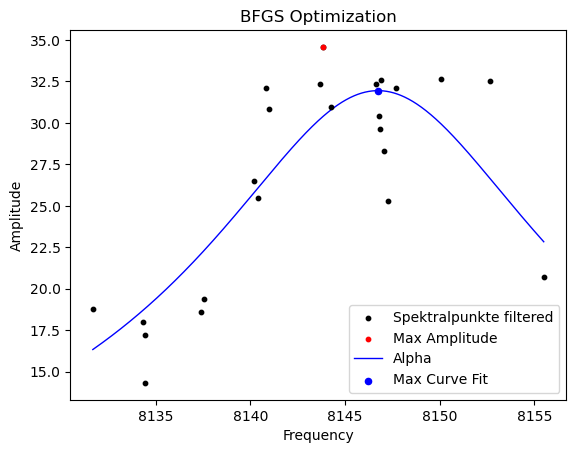

Optimized Parameters:
Resonant Frequency: 8146.746051852071
Damping Coefficient: 0.0010989248372497854
Force Amplitude: 0.07020956698446057
Resonant Amplitude: 31.94467402394625
Objective Function Value: 229.4092692624839


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 229.4092692624839
        x: [ 8.147e+03  1.099e-03  7.020e-02]
      nit: 20
      jac: [ 1.154e-03  8.419e+00 -1.765e-01]
     nfev: 180
     njev: 45
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [172]:
result = minimize(
    objective_function,
    initial_values,
    args=(J, N),
    bounds=bounds,
    options=options)
result
# Plotting
plt.scatter(
    df2["J"],
    df2["N"],
    color="black",
    label="Spektralpunkte filtered",
    zorder=5,
    s=10,
)
# color the max amplitude point red
plt.scatter(
    initial_Oeig,
    max_N,
    color="red",
    label="Max Amplitude",
    zorder=5,
    s=10,
)

plt.plot(
    X_pred,
    ypred_one_mass_oscillator,
    label="Alpha",
    color="blue",
    linewidth=1,
)
plt.scatter(
    resonant_frequency,
    resonant_amplitude,
    color="blue",
    label="Max Curve Fit",
    zorder=10,
    s=20,
)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("BFGS Optimization")
plt.show()

print("Optimized Parameters:")
print(f"Resonant Frequency: {resonant_frequency}")
print(f"Damping Coefficient: {D}")
print(f"Force Amplitude: {F}")
print(f"Resonant Amplitude: {resonant_amplitude}")
print(f"Objective Function Value: {result.fun}")
result


### Comparision of different Optimisers

| Optimizer           | Scope(local/Global optimizer)|Objective Function Value| Number of Evaluations|Number of Iterations| Observations             |
|---------------------|------------------------------|------------------------|----------------------|--------------------|--------------------------|
|Dual Annealing       | Global                        | 229.4092694161751      | 6181                  | 1000          |  Finds the optimal solution with the highest number of evaluations and iterations.    |
|DifferntialEvolution               | Global                       | 229.4192718479083     | 1778              | 37                  |  Achieves a near-optimal solution with fewer evaluations and iterations compared to dual annealing.|
|Nelder Mead       | Local                       | 229.4092648339145      | 239                 | 135               |  Efficiently converges to a near-optimal solution with minimal evaluations and iterations. |
|Powell's | local                       | 229.4092648056204     | 586                 | 9                 |   Powell's method efficiently finds a near-optimal solution with a lower number of iterations compared to Dual Annealing, but it may not find the absolute best solution   |
|L-BFGS-B | local                       | 229.4092692624839      | 180                 | 45                 |   Quickly reaches the optimal solution with the least number of evaluations and a moderate number of iterations.|

### Conclusion

Based on the table, there's a trade-off between finding the absolute best solution (global optimum) and the efficiency of the optimization algorithm. Algorithms that guarantee a global optimum (like Dual Annealing) require more evaluations and iterations. Conversely, faster algorithms (like Nelder-Mead or Powell's method) might converge to very good solutions (local optima) but potentially miss the absolute best.